In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import catboost as ctb
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
full_train = pd.read_csv('course_project_train.csv')
full_test = pd.read_csv('course_project_test.csv')

### Data fields

<ul>
    <li>Home Ownership - домовладение</li>
<li>Annual Income - годовой доход</li>
<li>Years in current job - количество лет на текущем месте работы</li>
<li>Tax Liens - налоговые обременения</li>
<li>Number of Open Accounts - количество открытых счетов</li>
<li>Years of Credit History - количество лет кредитной истории</li>
<li>Maximum Open Credit - наибольший открытый кредит</li>
<li>Number of Credit Problems - количество проблем с кредитом</li>
<li>Months since last delinquent - количество месяцев с последней просрочки платежа</li>
<li>Bankruptcies - банкротства</li>
<li>Purpose - цель кредита</li>
<li>Term - срок кредита</li>
<li>Current Loan Amount - текущая сумма кредита</li>
<li>Current Credit Balance - текущий кредитный баланс</li>
<li>Monthly Debt - ежемесячный долг</li>
<li>Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</li></ul>

In [4]:
full_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
full_train.isnull().sum()[full_train.isnull().sum()>0]

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

In [8]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Корреляционная матрица

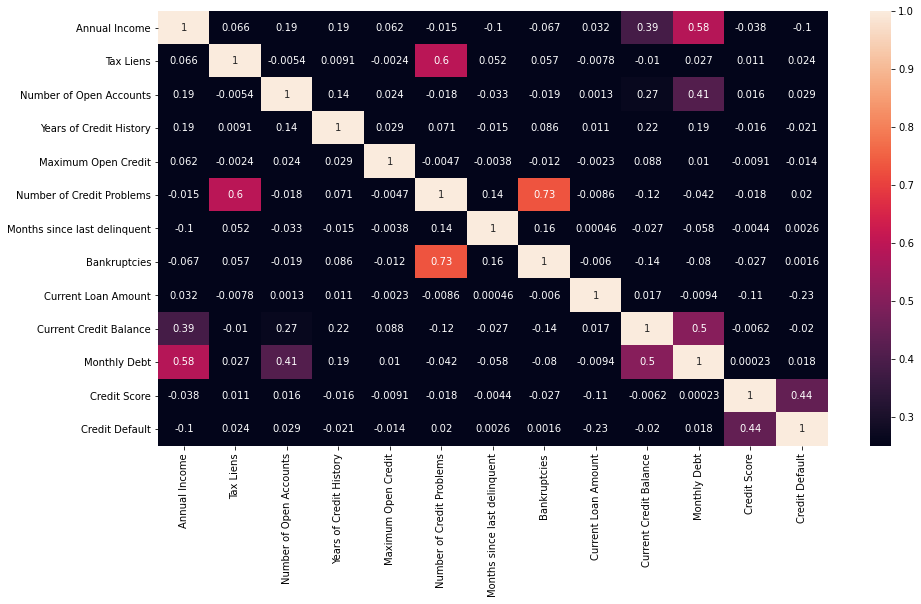

In [34]:
plt.figure(figsize=(15,8))
corrMatrix = full_train.corr()
sns.heatmap(corrMatrix, annot=True, vmin=0.25)
plt.show()

#### Графики распределения признаков

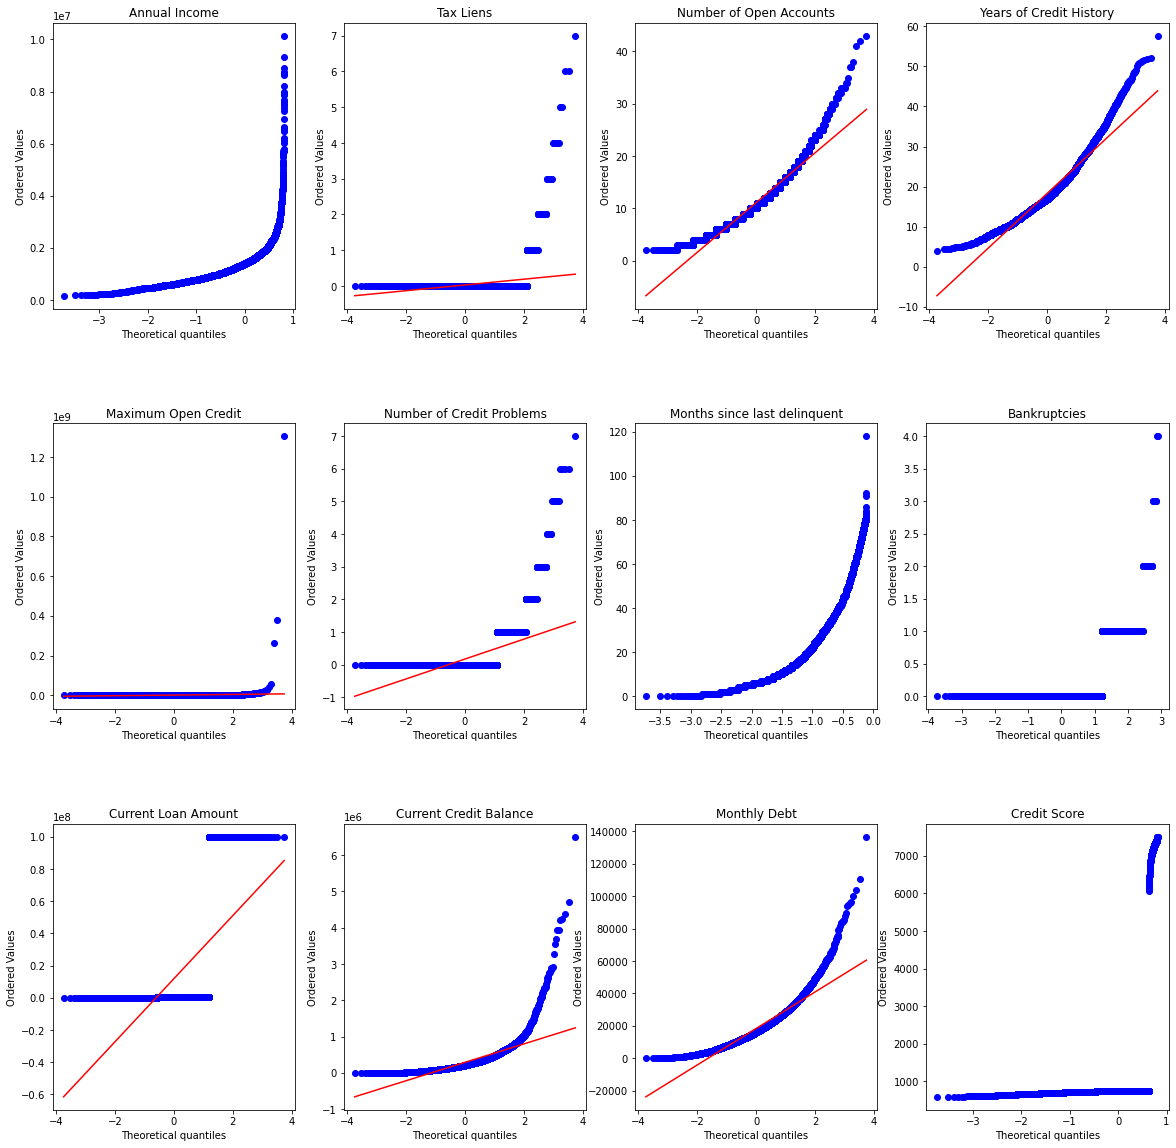

In [14]:
num_data = full_train.select_dtypes(include=np.number)
num_data = num_data.drop('Credit Default', axis=1)
f, a = plt.subplots(3,4, figsize=(20,20))
a = a.flatten().T
f.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col in enumerate(num_data.columns):
    stats.probplot(num_data[col], plot=a[i])
    a[i].set_title(col)
plt.show()

####  Глядя на графики можно сказать, что :<ol>
<li>Присутствуют сильно заметные выбросы в признаке 'Maximum Open Credit', со значениями больше 200000000 </li>
<li>Объекты в признаках 'Current Loan Amount' и 'Credit Score' разделены на 2 группы </li></ol>

#### Проанализируем распределение целевой переменной для объектов с высокими значениями в признаках 'Current Loan Amount' и 'Credit Score'

In [17]:
full_train[full_train['Credit Score']>5000]['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

In [18]:
full_train[full_train['Current Loan Amount']>1000000]['Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

Явно видно, что для этих групп объектов, на признак влияет по факту только одна переменная. 
Я пробовал предсказывать есть ли экстремальные значения в Credit Score для тестового датасета, убирать из обучающей выборки эти данные итд., но результаты были +- одни и те же, поэтому сюда не буду включать этот код.

#### Дополнительные переменные

In [3]:
curr_job_years = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
                  '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
term_dict = {'Long Term': 0, 'Short Term': 1}
AI_median = full_train['Annual Income'].median()
CS_median = full_train['Credit Score'].median()

#### Обработка данных

In [25]:
def data_preprocessing(df):
    df1 = df.copy()
    df1 = df1.drop('Months since last delinquent', axis=1)
    
    # обработка категориальных признаков, для которых были созданны словари
    df1['Term'] = pd.Series(df1['Term'].map(term_dict), dtype=np.int8)
    df1['Years in current job'] = pd.Series(df1['Years in current job'].map(curr_job_years), dtype=np.int8)
    
    # заполнение пропусков
    df1['Annual Income'].fillna(value=AI_median, inplace=True)
    df1['Credit Score'].fillna(value=CS_median, inplace=True)
    df1['Bankruptcies'].fillna(value=0, inplace=True)
    df1['Years in current job'].fillna(value=0, inplace=True)

    # дамми признаки
    df1 = pd.get_dummies(df1)
    if 'Purpose_renewable energy' in df1.columns:
        df1.drop('Purpose_renewable energy', axis=1, inplace=True)
    
    # новые признаки
    df1['No Tax Liens'] = df1['Tax Liens'].apply(lambda x: 1 if x == 0 else 0)
    df1['No Credit Problems'] = df1['Number of Credit Problems'].apply(lambda x: 1 if x == 0 else 0)
    df1['No Bankruptcies'] = df1['Bankruptcies'].apply(lambda x: 1 if x == 0 else 0)
    
    # обработка выбросов
    df1 = df1[df1['Maximum Open Credit']<200000000]
    
    
    return df1

In [35]:
train = full_train.copy()
test = full_test.copy()

train = data_preprocessing(train)
test = data_preprocessing(test)
train.shape, test.shape

((7497, 35), (2500, 34))

In [36]:
y = train['Credit Default']
X = train.drop('Credit Default', axis=1)

In [37]:
disbalance = y.value_counts()[0] / y.value_counts()[1]
disbalance

2.548035967818268

#### Создание модели

In [38]:
final_params = {'silent': True,
                 'random_state': 42,
                 'n_estimators': 800,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'class_weights': [1, disbalance],
                }

In [47]:
model = ctb.CatBoostClassifier(**final_params)

model.fit(X, y)
preds = model.predict(test)
preds

array([1, 1, 1, ..., 1, 0, 1])

#### Важность признаков

In [42]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

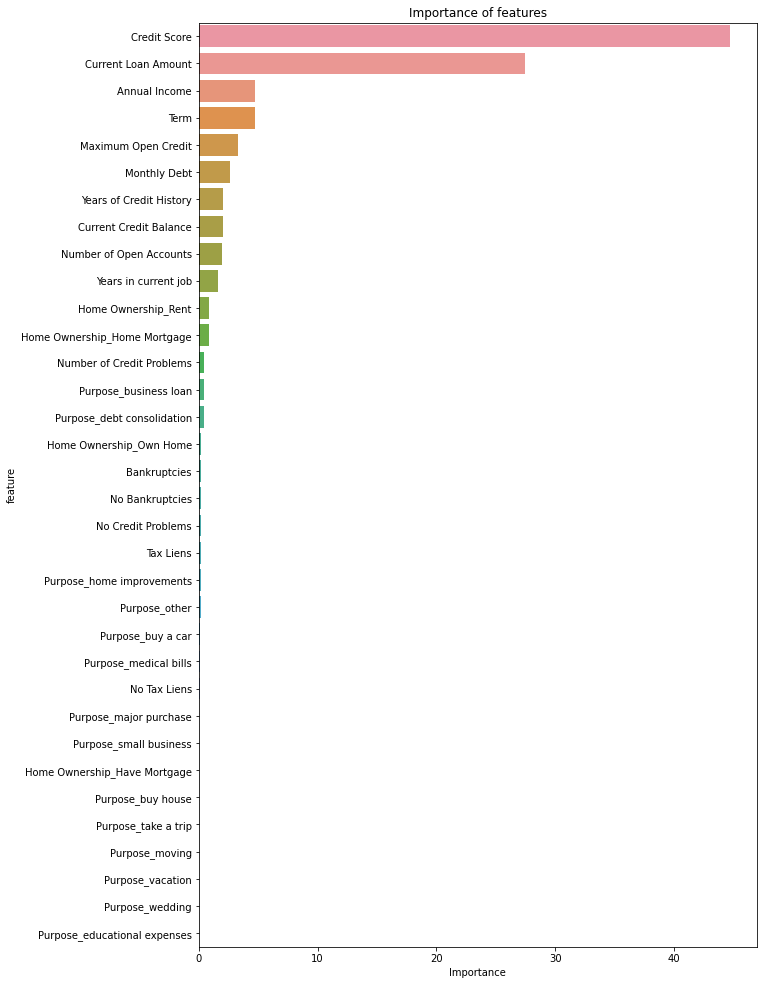

In [45]:
show_feature_importances(test.columns, model.feature_importances_)

#### Submission file


In [48]:
sub = pd.read_csv('sampleSubmission.csv')
sub['Id'] = sub['Id']-7500
sub['Credit Default'] = preds
sub.to_csv('ctb_sub', index=False)
sub

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


In [49]:
sub['Credit Default'].value_counts()

0    1602
1     898
Name: Credit Default, dtype: int64